In [10]:
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
Root = tfd.JointDistributionCoroutine.Root

<Axes: xlabel='date_month', ylabel='CO2'>

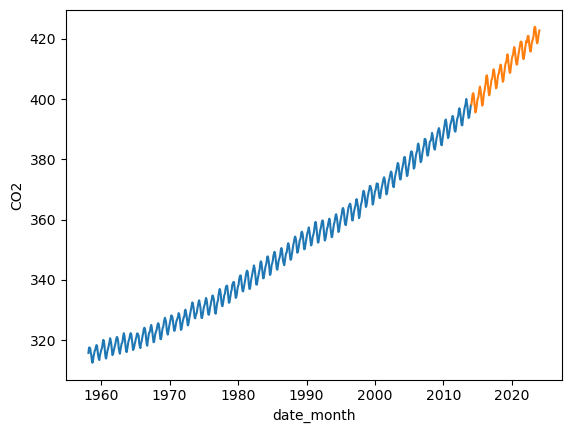

In [4]:
co2_by_month = pd.read_csv("co2_mm_mlo.csv",comment='#')
co2_by_month["date_month"] = pd.to_datetime(
    co2_by_month["year"].astype("str")
    .str.cat(['-']*co2_by_month.shape[0])
    .str.cat(co2_by_month["month"].astype("str"))
)
co2_by_month["CO2"] = co2_by_month["average"].astype(np.float32)
co2_by_month.set_index("date_month", drop=True, inplace=True)

num_forecast_steps = 12 * 10  # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]

sns.lineplot(co2_by_month_training_data, x="date_month", y="CO2")
sns.lineplot(co2_by_month_testing_data, x="date_month", y="CO2")

In [5]:
# trend/_all is column matrix (X_tnd)
trend_all = np.linspace(0., 1., len(co2_by_month))[...].astype(np.float32)
trend = trend_all[:-num_forecast_steps]

# seasonality is season-indicator matrix (X_sea)
seasonality_all = pd.get_dummies(
   co2_by_month.index.month
).values.astype(np.float32)
seasonality_all[:3,:]
seasonality = seasonality_all[:-num_forecast_steps,:]

print(trend.shape)
print(seasonality.shape)

(671,)
(671, 12)


In [6]:

@tfd.JointDistributionCoroutine
def ts_regression_model():
    intercept = yield Root(tfd.Normal(0., 100., name="intercept"))
    trend_coeff = yield Root(tfd.Normal(0., 10., name="trend_coeff"))
    seasonality_coeff = yield Root(
        tfd.Sample(
            tfd.Normal(0., 1.),
            sample_shape=seasonality.shape[-1],
            name="seasonality_coeff"
        )
    )
    noise = yield Root(tfd.HalfCauchy(loc=0., scale=5., name="noise_sigma"))
    y_hat = (
        intercept[..., None] +
        tf.einsum("i,...->...i", trend, trend_coeff) +
        tf.einsum("ij,...j->...i", seasonality, seasonality_coeff)
    )
    y_obs = yield tfd.Independent(
        tfd.Normal(y_hat, noise[...,None]),
        reinterpreted_batch_ndims=1,
        name="y_obs"
    )

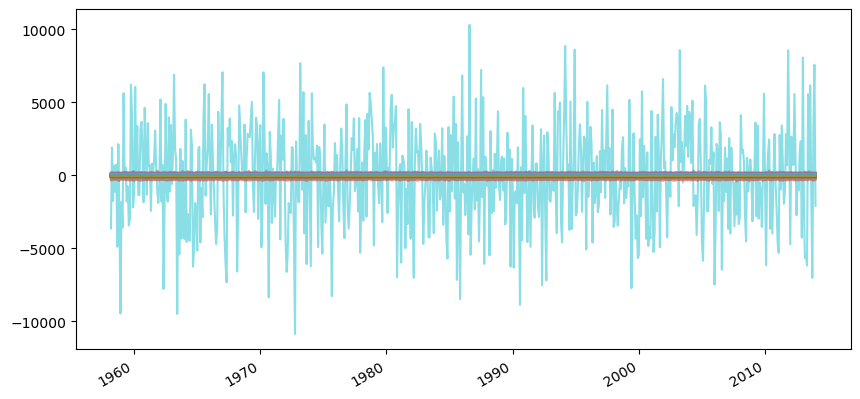

In [7]:
prior_samples = ts_regression_model.sample(100)  
prior_predictive_timeseries = prior_samples.y_obs
t = co2_by_month.index[:-num_forecast_steps]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t,tf.transpose(prior_samples.y_obs), alpha=.5)
fig.autofmt_xdate()

In [8]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False,
    jit_compile=True
)
mcmc_samples, sampler_stats = run_mcmc(
    1000,
    ts_regression_model,
    n_chains=4,
    num_adaptation_steps=1000,
    # Prepend batch index with [None]
    y_obs=co2_by_month_training_data["CO2"].values[None, ...]
)

2024-02-08 07:07:28.724113: I external/local_xla/xla/service/service.cc:168] XLA service 0x2c49bedb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-08 07:07:28.724128: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-02-08 07:07:28.880638: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-08 07:07:28.972111: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2024-02-08 07:07:29.040803: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1707404855.210695       1 device_compiler.h:186] Compiled 

In [11]:
regression_idata = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expects.
        k:np.swapaxes(v.numpy(), 1, 0)
        for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)
regression_idata

Inference data with groups:
	> posterior
	> sample_stats

In [12]:
n_chain = regression_idata.posterior.dims["chain"]

# Construct the posterior predictive on the data
post_trend = tf.transpose(mcmc_samples.intercept) + tf.einsum("i,...->i...", trend_all,regression_idata.posterior.trend_coeff)
post_seasonality = tf.einsum("ij,...j->i...", seasonality_all, regression_idata.posterior.seasonality_coeff)

post_y_dist = tfd.Normal(
     post_trend + post_seasonality,
     tf.transpose(mcmc_samples.noise_sigma)[None,...]
)
post_y_sample = post_y_dist.sample()

post_y_sample.shape

TensorShape([791, 4, 1000])

/var/folders/mh/2xmd8gxn1g94m_ptkk4trpl40000gp/T/ipykernel_24417/221659153.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


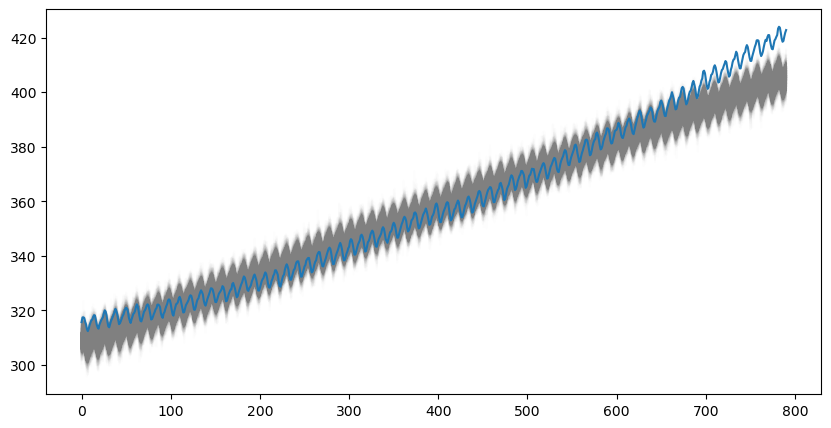

In [13]:
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(post_y_sample[:,2,:], alpha=.01, color='grey')
ax.plot(co2_by_month["CO2"].values)
fig.show()